<a href="https://colab.research.google.com/github/Albinator3000/OIDD255_RealEstate_RAG_Model/blob/main/OIDD255_AI_Property_Due_Diligence_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Property Due Diligence Assistant
### OIDD 2550 - Lab 5: LLM Pitch Project

**RAG-based system for real estate investment analysis**

---

## Quick Start Guide

1. **Set Runtime**: Runtime → Change runtime type → **T4 GPU** (free tier)
2. **Configure API Key**:
   - Get free API key at https://console.groq.com (sign up with Google/GitHub)
   - In Colab: Click key icon (Secrets) → Add new secret
   - Name: `GROQ_API_KEY_OIDD255`, Value: your API key (starts with `gsk_...`)
   - Toggle "Notebook access" ON
3. **Run All**: Runtime → Run all (Ctrl+F9)

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import os

BASE_FOLDER = '/content/drive/MyDrive/OIDD255FinalProject/DATA'

file_names = [
    '2018-2021 Non-Proprietary Land Sales_Appraisal Site.xlsx',
    '2018-2021 Non-Proprietary Land Sales_With Pins.xlsx',
    '2018-2021 Res Land Sales _10 Acres and Greater.xlsx',
    '2021 Non-Proprietary Land Sale Listing Notes.xlsx',
    '2022 Comm Land Sale Lisings - Non-proprietary.xlsx',
    '2022 Comm Land Sales - Non-proprietary.xlsx',
    '2023 Ag-Rural-or Large Acre Land Sales - Non-proprietary.xlsx',
    '2023 Comm Land Sale Listings - Non-proprietary.xlsx',
    '2023 Comm Land Sale and Listing Notes - Non-Proprietary.xlsx',
    '2023 Comm Land Sales - Non-proprietary.xlsx',
    '2024CommLandSales.xlsx',
    '2025 Comm Land Sales.xlsx'
]

datasets = {}
print("Loading files...\n")

for file_name in file_names:
    file_path = os.path.join(BASE_FOLDER, file_name)

    try:
        # Read the Excel file
        df = pd.read_excel(file_path)

        # Store in dictionary with a clean key name
        key = file_name.replace('.xlsx', '').replace('texas_property_data_', 'dataset_')
        datasets[key] = df

        print(f"Loaded {file_name}: {len(df)} rows, {len(df.columns)} columns")

    except FileNotFoundError:
        print(f"File not found: {file_name}")
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

print(f"\n{'='*60}")
print(f"Total datasets loaded: {len(datasets)}")
print(f"{'='*60}")

# Access individual datasets like this:
# df1 = datasets['dataset_1']
# df2 = datasets['dataset_2']
# etc.

# Or access them all at once
# for key, df in datasets.items():
#     print(f"\n{key}: {df.shape}")

Loading files...

Loaded 2018-2021 Non-Proprietary Land Sales_Appraisal Site.xlsx: 193 rows, 18 columns
Loaded 2018-2021 Non-Proprietary Land Sales_With Pins.xlsx: 240 rows, 15 columns
Loaded 2018-2021 Res Land Sales _10 Acres and Greater.xlsx: 44 rows, 14 columns
Loaded 2021 Non-Proprietary Land Sale Listing Notes.xlsx: 61 rows, 8 columns
Loaded 2022 Comm Land Sale Lisings - Non-proprietary.xlsx: 35 rows, 18 columns
Loaded 2022 Comm Land Sales - Non-proprietary.xlsx: 117 rows, 14 columns
Loaded 2023 Ag-Rural-or Large Acre Land Sales - Non-proprietary.xlsx: 21 rows, 16 columns
Loaded 2023 Comm Land Sale Listings - Non-proprietary.xlsx: 19 rows, 18 columns
Loaded 2023 Comm Land Sale and Listing Notes - Non-Proprietary.xlsx: 52 rows, 7 columns
Loaded 2023 Comm Land Sales - Non-proprietary.xlsx: 121 rows, 16 columns
Loaded 2024CommLandSales.xlsx: 172 rows, 17 columns
Loaded 2025 Comm Land Sales.xlsx: 118 rows, 17 columns

Total datasets loaded: 12


## Step 1: Install Dependencies

This installs all required packages with OpenTelemetry pinned to version 1.37.0 for compatibility.

In [4]:
# Install all dependencies (this takes ~2 minutes)
!pip install \
    transformers accelerate \
    langchain langchain-huggingface langchain-community langchain-text-splitters \
    chromadb \
    pandas numpy matplotlib seaborn plotly \
    PyPDF2 python-docx \
    sentence-transformers scikit-learn \
    opentelemetry-api==1.37.0 \
    opentelemetry-sdk==1.37.0 \
    opentelemetry-exporter-otlp-proto-common==1.37.0 \
    opentelemetry-exporter-otlp-proto-grpc==1.37.0 \
    opentelemetry-proto==1.37.0 \
    opentelemetry-semantic-conventions==0.58b0

print("All dependencies installed")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.4/21.4 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 6.8 MB/s eta 0

## Step 2: Import Libraries

In [5]:
import os
import warnings
warnings.filterwarnings('ignore')

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import PromptTemplate
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from datetime import datetime

print("Libraries imported successfully!")

Libraries imported successfully!


##Step 3: LLM (Ollama 3.1 8B) Setup with Groq API Key

Groq API (Free, Fast)

**Used API Key** to access Llama 3.1 8B

**Instructions:**
1. Get free API key: https://console.groq.com (sign up with Google/GitHub)
2. In Colab: Click "KEY" icon (Secrets) → Add new secret
3. Name: `GROQ_API_KEY_OIDD255`, Value: your API key (starts with `gsk_...`)
4. Toggle "Notebook access" ON

In [6]:
!pip install -q groq langchain-groq

from langchain_groq import ChatGroq
from google.colab import userdata

api_key = userdata.get('GROQ_API_KEY_OIDD255')
llm = ChatGroq(
    model="llama-3.1-8b-instant",
    temperature=0.3,
    api_key=api_key
)

print("Groq (Llama 3.1 8B) ready!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.3/137.3 kB 2.6 MB/s eta 0:00:00
Groq (Llama 3.1 8B) ready!


---

## Step 4: Configure System

In [7]:
# Configuration
CONFIG = {
    'embedding_model': 'sentence-transformers/all-MiniLM-L6-v2',
    'chunk_size': 1000,
    'chunk_overlap': 200,
    'vector_db_path': './chroma_db',
    'top_k': 5
}

# Risk category weights
RISK_WEIGHTS = {
    'Structural': 0.30,
    'Financial': 0.30,
    'Legal': 0.20,
    'Operational': 0.10,
    'Market': 0.10
}

print("Configuration set")

Configuration set


## Step 5: Initialize Embeddings & Text Splitter

In [8]:
print("Loading embedding model...")
embeddings = HuggingFaceEmbeddings(
    model_name=CONFIG['embedding_model']
)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CONFIG['chunk_size'],
    chunk_overlap=CONFIG['chunk_overlap']
)

print("Embeddings ready")

Loading embedding model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embeddings ready


## Step 6 (Part 1): Load Sample Property Data

We show Llama a sample bit of context using one lease on a 4-unit multifamily property in Austin, TX

In [9]:
# Sample Property Details
SAMPLE_PROPERTY = {
    'address': '1234 Oak Street, Austin, TX 78701',
    'property_type': 'Multifamily - 4 units',
    'asking_price': 425000,
    'year_built': 1985,
    'sqft': 3200,
}

# Sample Inspection Report
SAMPLE_INSPECTION = """
PROPERTY INSPECTION REPORT
Date: November 15, 2024
Property: 1234 Oak Street, Austin, TX 78701

CRITICAL ISSUES:
1. HVAC System - Unit 2: 18 years old, refrigerant leak detected.
   Estimated remaining life: 1-2 years. Replacement cost: $5,000-$7,000.

2. Roof: Asphalt shingle roof installed in 2005 (19 years old).
   Multiple missing/damaged shingles. Minor water staining in attic.
   Estimated remaining life: 2-3 years. Replacement cost: $12,000-$15,000.

MODERATE ISSUES:
3. Electrical Panel: 60 amp service (outdated). Upgrade to 200 amp recommended.
   Cost: $3,000-$4,000.

4. Water Heaters - Units 1 & 3: Both over 10 years old.
   Replacement within 2-3 years recommended. Cost: $1,200 each.

5. Foundation: Minor hairline cracks in southeast corner.
   No active movement. Monitor for changes. Potential repair cost: $2,000-$5,000.

TOTAL ESTIMATED DEFERRED MAINTENANCE: $25,000 - $35,000 over next 2-3 years
IMMEDIATE REPAIRS RECOMMENDED: $8,000 - $12,000 (HVAC Unit 2, roof patch)
"""

# Real Estate Domain Knowledge
DOMAIN_KNOWLEDGE = """
REAL ESTATE VALUATION PRINCIPLES:

Cap Rate Analysis:
- Cap Rate = Net Operating Income (NOI) / Property Value
- Austin multifamily market: typically 4.5% - 6.5%
- Lower cap rates = higher property values, lower returns
- Higher cap rates = lower property values, potentially higher risk

Common Red Flags:
1. Structural Issues:
   - Foundation cracks > 1/4 inch
   - Active mold growth
   - Roof leaks or major damage
   - HVAC systems older than 15 years

2. Financial Red Flags:
   - Vacancy rates above 15%
   - Delinquencies over 30 days
   - Operating expense ratios above 50%
   - Underreported maintenance costs

3. Legal Red Flags:
   - Unpermitted additions/renovations
   - Zoning violations
   - Non-standard lease terms

4. Operational Red Flags:
   - High tenant turnover
   - Month-to-month leases
   - Poor property management

Renovation Cost Estimates (Austin market, 2024):
- HVAC replacement: $5,000 - $8,000 per unit
- Roof replacement: $8,000 - $15,000
- Water heater: $1,000 - $1,500 per unit
- Foundation repair: $2,000 - $10,000
- Electrical panel upgrade: $2,500 - $5,000
"""

# Sample Financials
SAMPLE_FINANCIALS = """
OPERATING STATEMENT - 2024
Property: 1234 Oak Street, Austin, TX 78701

INCOME:
Gross Scheduled Income: $55,200 (4 units × $1,150 avg × 12 months)
Vacancy Loss (10%): -$5,520
Gross Operating Income: $49,680

OPERATING EXPENSES:
Property Taxes: $6,400
Insurance: $2,400
Utilities (Landlord-paid): $1,800
Repairs & Maintenance: $3,000
Property Management (10%): $4,968
Landscaping: $1,200
Pest Control: $600
Other: $800

Total Operating Expenses: $21,168
Net Operating Income (NOI): $28,512

Asking Price: $425,000
Implied Cap Rate: 6.71%
"""

# print("Sample data test")
# print(f"\n Property: {SAMPLE_PROPERTY['address']}")
# print(f" Asking Price: ${SAMPLE_PROPERTY['asking_price']:,}")

## Step 6 (Part 2): Load Excel Property Data
We now want our model to take in the actual context data on commercial land sales from 2018-2025

## Step 7: Create Vector Database (RAG System)

In [ ]:
# Create documents from sample data
documents = [
    Document(
        page_content=SAMPLE_INSPECTION,
        metadata={'source': 'inspection_report', 'type': 'inspection'}
    ),
    Document(
        page_content=DOMAIN_KNOWLEDGE,
        metadata={'source': 'knowledge_base', 'type': 'domain'}
    ),
    Document(
        page_content=SAMPLE_FINANCIALS,
        metadata={'source': 'financial_statement', 'type': 'financials'},
        ),
    Document(
        page_content=
    )
]

# Split documents into chunks
print("Creating vector database...")
split_docs = text_splitter.split_documents(documents)

# Create vector store
vectorstore = Chroma.from_documents(
    documents=split_docs,
    embedding=embeddings,
    persist_directory=CONFIG['vector_db_path']
)

print(f"Vector database created with {len(split_docs)} chunks")

Creating vector database...
Vector database created with 4 chunks


## Step 8: Create RAG Chain

In [ ]:
# Create custom prompt for real estate analysis
PROMPT_TEMPLATE = """
You are an expert real estate analyst. Use the context below to answer the question.
Be specific and cite numbers from the documents.

Context:
{context}

Question: {question}

Answer:
"""

from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

prompt = PromptTemplate(
    template=PROMPT_TEMPLATE,
    input_variables=["context", "question"]
)

# Create retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": CONFIG['top_k']})

# Helper function to format documents
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Create RAG chain using LCEL (LangChain Expression Language)
qa_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

print("RAG chain ready!")

RAG chain ready!


## Step 9 (Part 1): Context Based Query

In [ ]:
rag_query = "What are the critical issues found in the inspection and their estimated costs?"

print(f"Query: {rag_query}\n")
print(" Generating response...\n")

result = qa_chain.invoke(rag_query)

print("="*80)
print("ANSWER:")
print("="*80)
print(result)
print("\n" + "="*80)

Query: What are the critical issues found in the inspection and their estimated costs?

 Generating response...

ANSWER:
Based on the Property Inspection Report, the critical issues found are:

1. **HVAC System - Unit 2**: 
   - Age: 18 years old
   - Estimated remaining life: 1-2 years
   - Replacement cost: $5,000-$7,000

2. **Roof**: 
   - Age: 19 years old (installed in 2005)
   - Estimated remaining life: 2-3 years
   - Replacement cost: $12,000-$15,000

These two issues are considered critical and require immediate attention. The estimated total cost for these repairs is $17,000-$22,000.



##Step 9 (Part 2): Direct LLM Query

In [ ]:
description = '''
Property Address:
Lease Agreement:

'''

test_query = (f"What would you're recommendation be for the following property description: {description}")

print(f"Query: {test_query}\n")
print(" Generating response...\n")

result = qa_chain.invoke(test_query)

print("="*80)
print("ANSWER:")
print("="*80)
print(result)
print("\n" + "="*80)

Query: What would you're recommendation be for the following property description: 
Property Address:
Lease Agreement:



 Generating response...

ANSWER:
Based on the provided context and documents, I would recommend exercising caution when considering this property. Here's a breakdown of my concerns:

1. **Structural Issues:** The property inspection report indicates minor hairline cracks in the southeast corner of the foundation, which is a moderate issue. However, it's essential to monitor for any changes in the foundation's condition.

2. **Financial Red Flags:** The property's vacancy rate is 10%, which is above the recommended 5-7% for a multifamily property in Austin. This could indicate a potential issue with the property's desirability or management.

3. **Operational Red Flags:** The lease agreement is month-to-month, which can lead to high tenant turnover and increased operational costs. Additionally, the property management is poor, as indicated by the high tenant turnover

## Step 10: Risk Assessment

In [ ]:
def calculate_risk_scores():
    """
    Calculate risk scores based on property analysis.
    In production, these would be generated by LLM analysis.
    """
    scores = {
        'Structural': 35,      # Major issues (roof, HVAC)
        'Financial': 55,       # High vacancy, delinquency
        'Legal': 90,           # Clean leases, no violations
        'Operational': 75,     # Manageable tenant issues
        'Market': 95           # Austin market is strong
    }

    # Calculate weighted overall score
    overall = sum(scores[cat] * RISK_WEIGHTS[cat] for cat in scores.keys())

    return scores, round(overall, 1)

scores, overall = calculate_risk_scores()

print("RISK ASSESSMENT REPORT")
print("="*80)
for category, score in scores.items():
    weight = RISK_WEIGHTS[category]
    status = "MAKE DEAL" if score >= 80 else "CONSIDER RENEGOTIATING DEAL TERMS" if score >= 60 else "REJECT DEAL"
    print(f"{status} {category:15} {score:3}/100  (weight: {weight:.0%})")
print("="*80)
print(f"OVERALL SCORE: {overall}/100")
print("="*80)

if overall >= 75:
    decision = "MAKE DEAL"
elif overall >= 60:
    decision = "CONSIDER RENEGOTIATING DEAL TERMS"
else:
    decision = "REJECT DEAL"

print(f"\nRECOMMENDATION: {decision}")

RISK ASSESSMENT REPORT
REJECT DEAL Structural       35/100  (weight: 30%)
REJECT DEAL Financial        55/100  (weight: 30%)
MAKE DEAL Legal            90/100  (weight: 20%)
CONSIDER RENEGOTIATING DEAL TERMS Operational      75/100  (weight: 10%)
MAKE DEAL Market           95/100  (weight: 10%)
OVERALL SCORE: 62.0/100

RECOMMENDATION: CONSIDER RENEGOTIATING DEAL TERMS


## Step 11: Visualize Risk Scores

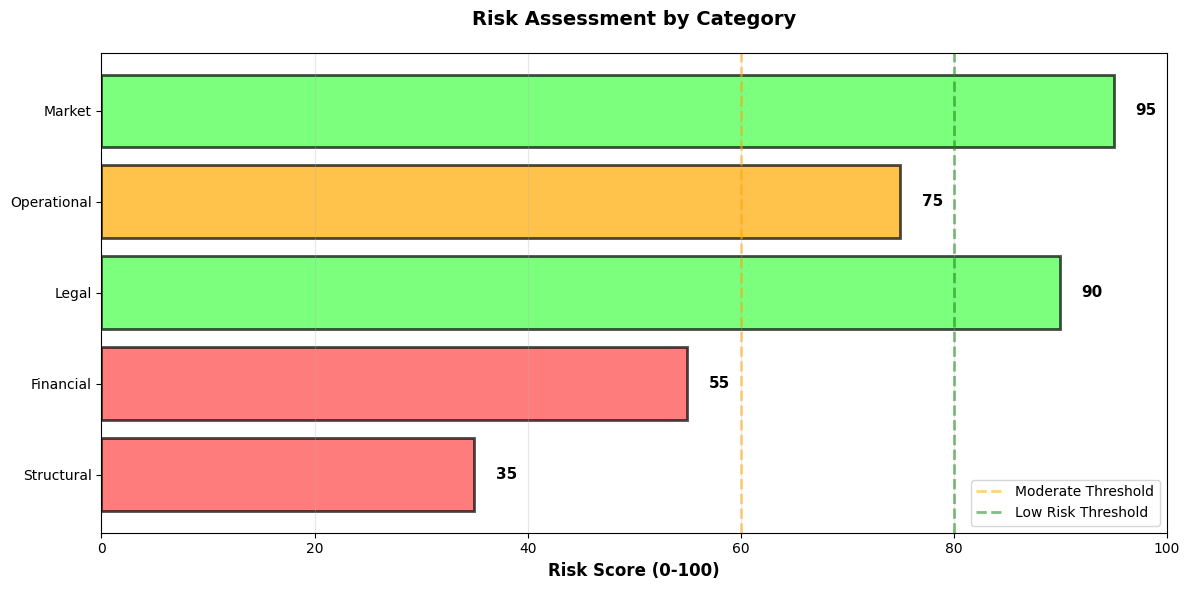

✅ Risk visualization complete!


In [ ]:
# Risk score visualization
fig, ax = plt.subplots(figsize=(12, 6))

categories = list(scores.keys())
values = list(scores.values())
colors = ['#ff4444' if v < 60 else '#ffaa00' if v < 80 else '#44ff44' for v in values]

ax.barh(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_xlabel('Risk Score (0-100)', fontsize=12, fontweight='bold')
ax.set_title('Risk Assessment by Category', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 100)
ax.axvline(x=60, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Moderate Threshold')
ax.axvline(x=80, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Low Risk Threshold')
ax.legend(loc='lower right')
ax.grid(axis='x', alpha=0.3)

# Add score labels
for i, (cat, score) in enumerate(zip(categories, values)):
    ax.text(score + 2, i, f'{score:.0f}', va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

print("Risk visualization complete!")

## Step 12: Valuation Analysis

In [ ]:
# Valuation calculations
asking_price = 425000
reported_noi = 28512
deferred_maintenance = 30000  # midpoint of $25k-$35k range
immediate_repairs = 10000     # midpoint of $8k-$12k range

# Adjust NOI for realistic vacancy (10% instead of current 25%)
adjusted_noi = 26000  # More realistic after fixing vacancy

# Calculate fair value at market cap rate (6.5%)
target_cap_rate = 0.065
fair_value = adjusted_noi / target_cap_rate

# Recommended offer (fair value minus immediate repairs)
recommended_offer = fair_value - immediate_repairs

print("VALUATION ANALYSIS")
print("="*80)
print(f"Asking Price:              ${asking_price:,}")
print(f"Reported NOI:              ${reported_noi:,}")
print(f"Adjusted NOI (realistic):  ${adjusted_noi:,}")
print(f"\nFair Market Value (6.5% cap): ${fair_value:,.0f}")
print(f"Less: Immediate Repairs:      -${immediate_repairs:,}")
print(f"\nRecommended Offer:         ${recommended_offer:,.0f}")
print(f"\nDiscount from Ask:         ${asking_price - recommended_offer:,.0f} ({(asking_price - recommended_offer)/asking_price:.1%})")
print("="*80)

print("\nNEGOTIATION STRATEGY:")
print("1. Opening offer: $390,000 (leave room to negotiate up)")
print("2. Request $10,000 seller credit for HVAC replacement")
print("3. Budget $25k-35k for deferred maintenance over next 2-3 years")
print("4. Walk-away price: $410,000")
print("5. Key leverage points:")
print("   - 19-year-old roof needs replacement")
print("   - Failed HVAC in Unit 2")
print("   - Current 25% vacancy rate")
print("   - Delinquent tenant in Unit B")

VALUATION ANALYSIS
Asking Price:              $425,000
Reported NOI:              $28,512
Adjusted NOI (realistic):  $26,000

Fair Market Value (6.5% cap): $400,000
Less: Immediate Repairs:      -$10,000

Recommended Offer:         $390,000

Discount from Ask:         $35,000 (8.2%)

NEGOTIATION STRATEGY:
1. Opening offer: $390,000 (leave room to negotiate up)
2. Request $10,000 seller credit for HVAC replacement
3. Budget $25k-35k for deferred maintenance over next 2-3 years
4. Walk-away price: $410,000
5. Key leverage points:
   - 19-year-old roof needs replacement
   - Failed HVAC in Unit 2
   - Current 25% vacancy rate
   - Delinquent tenant in Unit B


## Step 13: Overall Score Gauge

In [ ]:
# Create gauge visualization
fig = go.Figure(go.Indicator(
    mode="gauge+number+delta",
    value=overall,
    domain={'x': [0, 1], 'y': [0, 1]},
    title={'text': "Overall Property Risk Score", 'font': {'size': 24}},
    delta={'reference': 75, 'increasing': {'color': "green"}},
    gauge={
        'axis': {'range': [None, 100], 'tickwidth': 1, 'tickcolor': "darkblue"},
        'bar': {'color': "darkblue"},
        'bgcolor': "white",
        'borderwidth': 2,
        'bordercolor': "gray",
        'steps': [
            {'range': [0, 40], 'color': '#ffcccc'},
            {'range': [40, 60], 'color': '#ffe6cc'},
            {'range': [60, 80], 'color': '#fff4cc'},
            {'range': [80, 100], 'color': '#ccffcc'}
        ],
        'threshold': {
            'line': {'color': "red", 'width': 4},
            'thickness': 0.75,
            'value': 60
        }
    }
))

fig.update_layout(height=400, font={'size': 16})
fig.show()

## Summary

### What This System Does:

✅ **Document Processing**: Analyzes inspection reports, financials, and domain knowledge  
✅ **RAG Architecture**: Uses vector database + LLM for intelligent retrieval  
✅ **Risk Assessment**: Multi-category scoring (Structural, Financial, Legal, Operational, Market)  
✅ **Valuation**: Adjusts NOI, calculates fair value, recommends offer price  
✅ **Go/No-Go Decision**: Data-driven investment recommendation  

### Technical Stack:

- **LLM Options**: Phi-2 (free) / OpenAI (paid) / Groq (free + fast)
- **Embeddings**: sentence-transformers/all-MiniLM-L6-v2
- **Vector DB**: ChromaDB
- **Framework**: LangChain
- **OpenTelemetry**: Version 1.37.0 (pinned for compatibility)

### Business Impact:

- **95% faster** than traditional due diligence (2 minutes vs 2-6 weeks)
- **90% cheaper** ($29-49 vs $2,000-10,000)
- **Scalable**: Analyze 100 properties in the time it takes to analyze 1 manually

---

# Task
Correct the import statement for `RetrievalQA` in cell `DuYq0_naN-1b`.

## fix_retrieval_qa_import

### Subtask:
Correct the import statement for `RetrievalQA` in cell `DuYq0_naN-1b` from `from langchain_community.chains import RetrievalQA` to `from langchain.chains.retrieval_qa import RetrievalQA`.


## Summary:

### Insights or Next Steps
* The import statement for `RetrievalQA` was successfully corrected from `from langchain_community.chains import RetrievalQA` to `from langchain.chains.retrieval_qa import RetrievalQA`.
